<a href="https://colab.research.google.com/github/anshita195/Credit-Card-Behaviour-Score-Prediction/blob/main/Credit_Card_Behaviour_Score_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           fbeta_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, precision_recall_curve,
                           make_scorer)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
import os

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
plt.style.use('default')  # Use default style first
sns.set_theme()  # Then apply seaborn's theme

In [ ]:
os.makedirs('output', exist_ok=True)

In [ ]:

from google.colab import files

print("Click 'Choose Files' to upload the training file.")
train_upload = files.upload()

print("Click 'Choose Files' to upload the validation file.")
val_upload = files.upload()

print("\nUploaded files:")
print("Training file:", list(train_upload.keys())[0] if train_upload else "Not uploaded")
print("Validation file:", list(val_upload.keys())[0] if val_upload else "Not uploaded")

print("\nLoading datasets...")
try:
    train_data = pd.read_csv('train_dataset_final1.csv')
    val_data = pd.read_csv('validate_dataset_final.csv')

    print("\nDataset shapes:")
    print("Training Data Shape:", train_data.shape)
    print("Validation Data Shape:", val_data.shape)
except Exception as e:
    print("\nError loading datasets:")
    print(f"Error message: {str(e)}")
    print("\nPlease make sure both files are uploaded correctly and try again.")
    raise


Click 'Choose Files' to upload the training file.


Saving train_dataset_final1.csv to train_dataset_final1 (1).csv
Click 'Choose Files' to upload the validation file.


Saving validate_dataset_final.csv to validate_dataset_final (1).csv

Uploaded files:
Training file: train_dataset_final1 (1).csv
Validation file: validate_dataset_final (1).csv

Loading datasets...

Dataset shapes:
Training Data Shape: (25247, 27)
Validation Data Shape: (5016, 26)


 2. Exploratory Data Analysis (EDA)

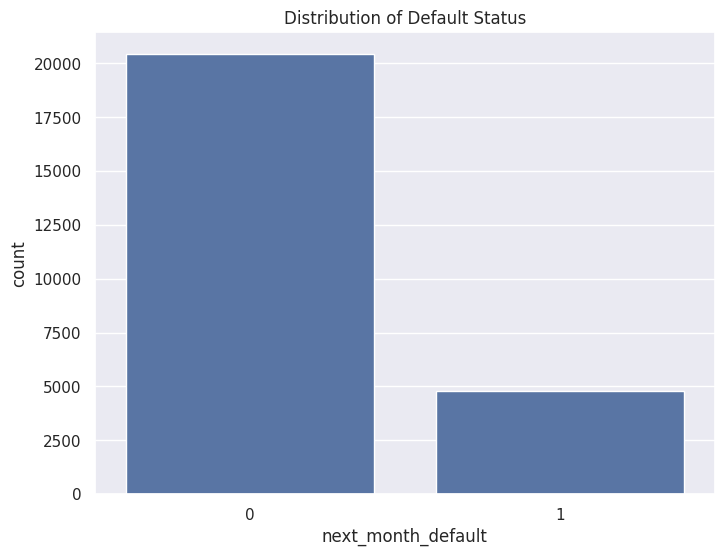


Default Rate: 0.19039885927040837


In [ ]:
# Target distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='next_month_default')
plt.title('Distribution of Default Status')
plt.savefig('output/default_distribution.png')
plt.show()

print("\nDefault Rate:", train_data['next_month_default'].mean())


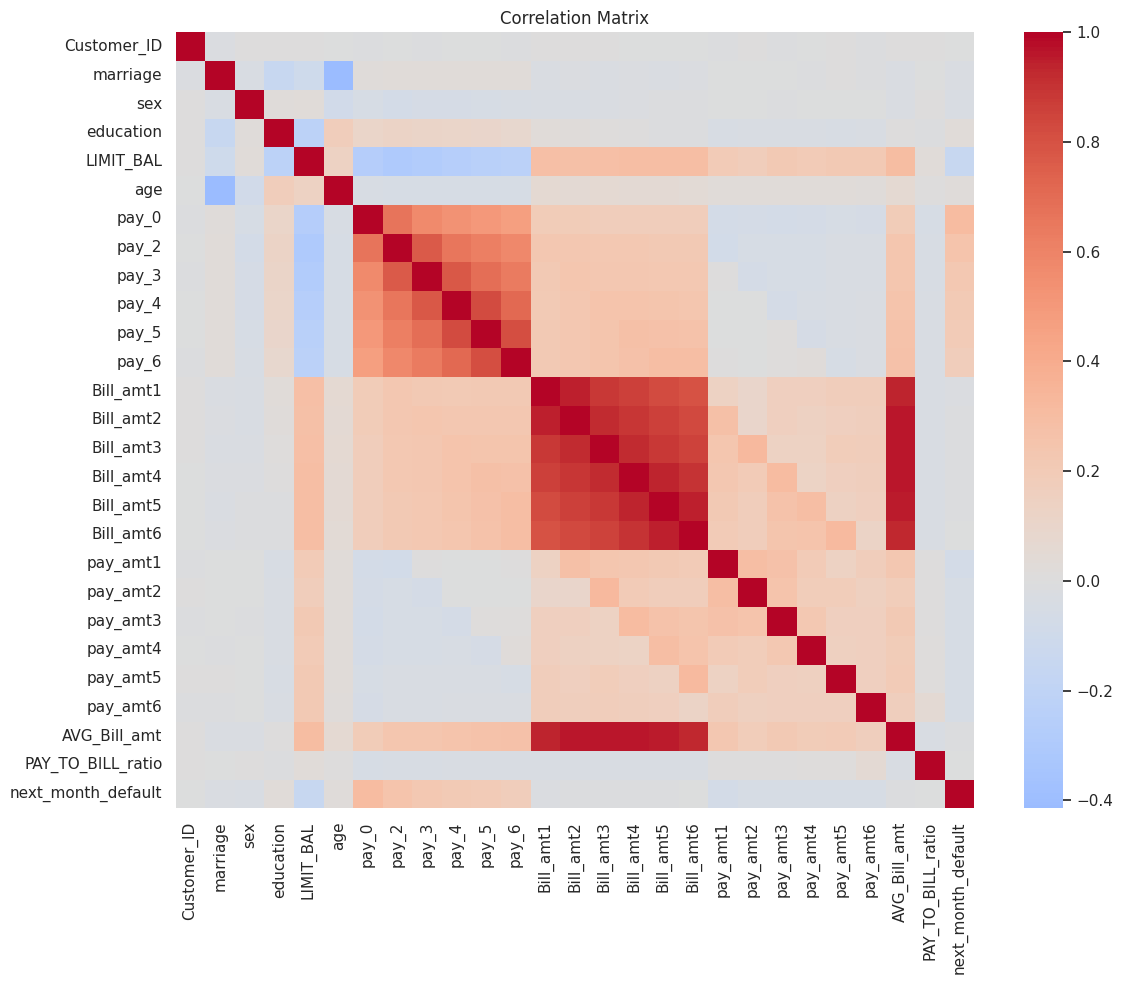

In [ ]:
# Correlation analysis
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('output/correlation_matrix.png')
plt.show()

In [ ]:
# Find top correlations with target
target_correlations = correlation_matrix['next_month_default'].sort_values(ascending=False)
print("\nTop 10 correlations with target:")
print(target_correlations.head(10))

# Save correlation analysis
target_correlations.to_csv('output/target_correlations.csv')


Top 10 correlations with target:
next_month_default    1.000000
pay_0                 0.312943
pay_2                 0.252125
pay_3                 0.226015
pay_4                 0.207488
pay_5                 0.196329
pay_6                 0.180387
education             0.026943
age                   0.017731
Customer_ID          -0.001893
Name: next_month_default, dtype: float64


In [ ]:
# Financial insights
financial_insights = {
    'Default Rate': train_data['next_month_default'].mean(),
    'Average Credit Limit': train_data['LIMIT_BAL'].mean(),
    'Average Bill Amount': train_data['AVG_Bill_amt'].mean(),
    'Payment to Bill Ratio': train_data['PAY_TO_BILL_ratio'].mean()
}

print("\nFinancial Insights:")
for key, value in financial_insights.items():
    print(f"{key}: {value:,.2f}")

# Save financial insights
pd.Series(financial_insights).to_csv('output/financial_insights.csv')


Financial Insights:
Default Rate: 0.19
Average Credit Limit: 168,342.06
Average Bill Amount: 44,859.65
Payment to Bill Ratio: 0.36



Selected key features based on correlation:
['next_month_default', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'education', 'age', 'Customer_ID']


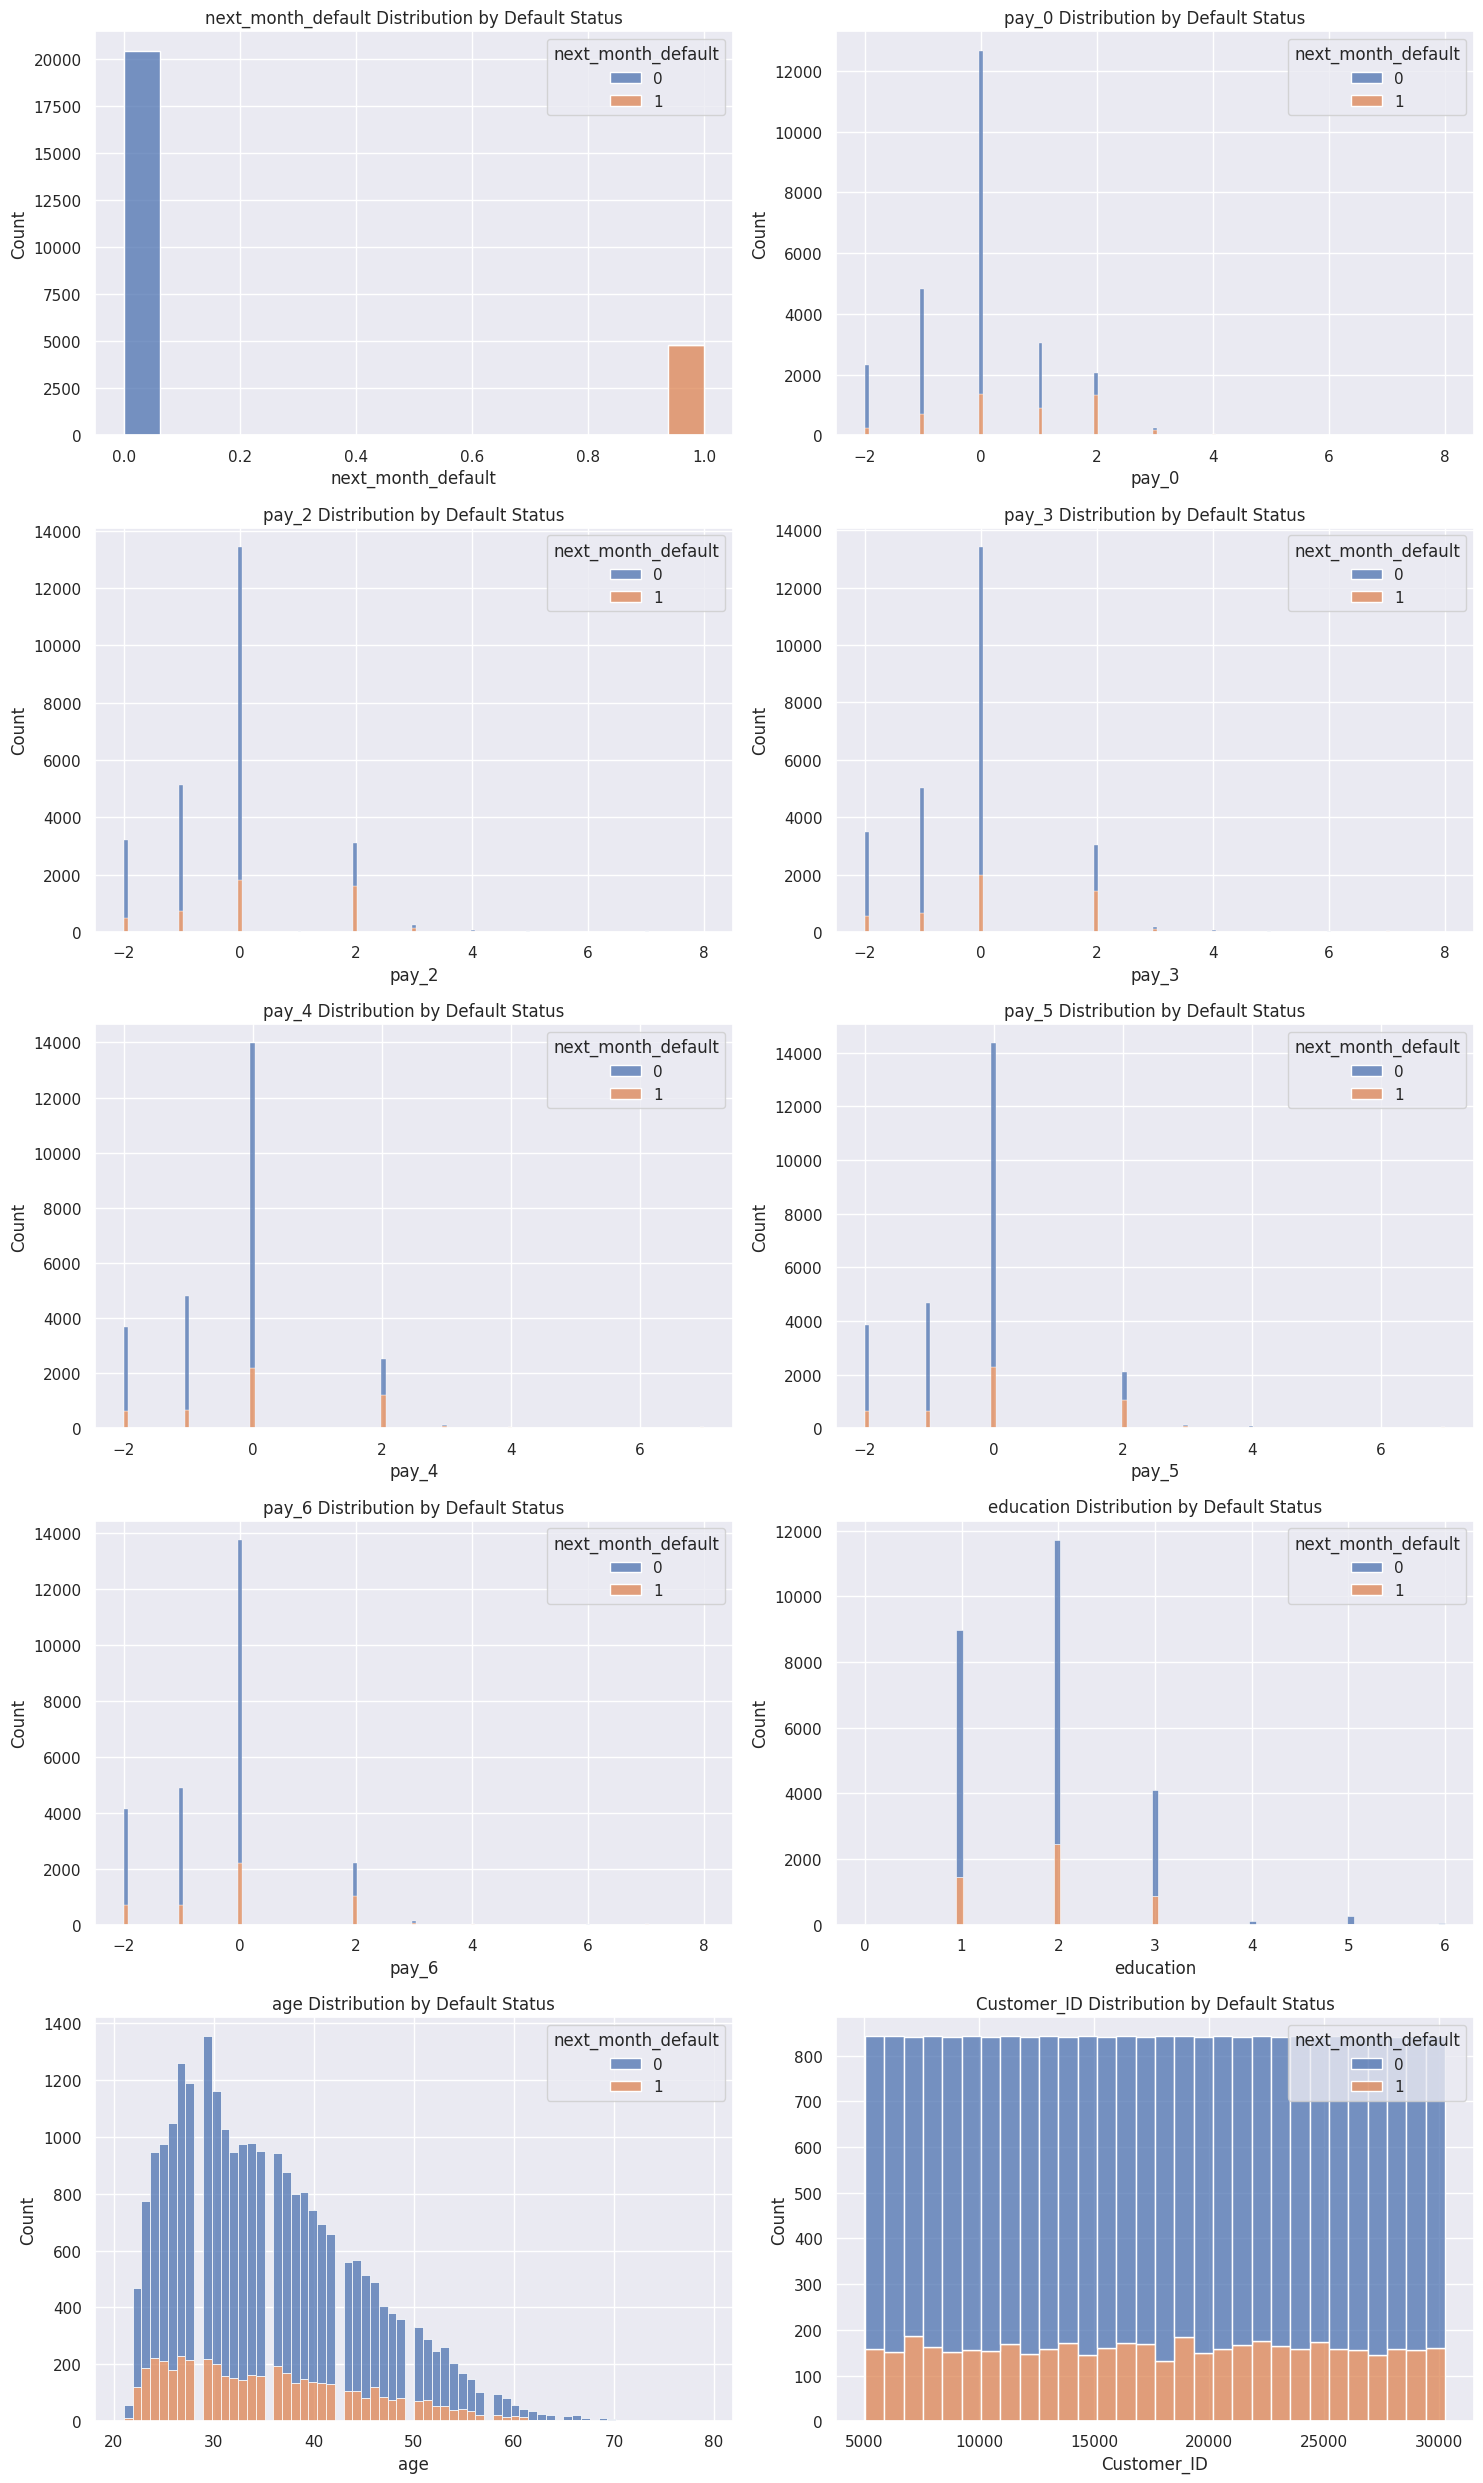

In [ ]:
# Feature distributions for key features
key_features = target_correlations.head(10).index.tolist()
print("\nSelected key features based on correlation:")
print(key_features)

n_features = len(key_features)
n_rows = (n_features + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    sns.histplot(data=train_data, x=feature, hue='next_month_default',
               multiple="stack", ax=axes[idx])
    axes[idx].set_title(f'{feature} Distribution by Default Status')

# Hide empty subplots if any
for idx in range(len(key_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('output/feature_distributions.png')
plt.show()

In [ ]:
# Payment History Analysis
pay_cols = [col for col in train_data.columns if col.startswith('pay_')]
pay_stats = train_data[pay_cols].describe()
pay_stats.to_csv('output/payment_history_stats.csv')

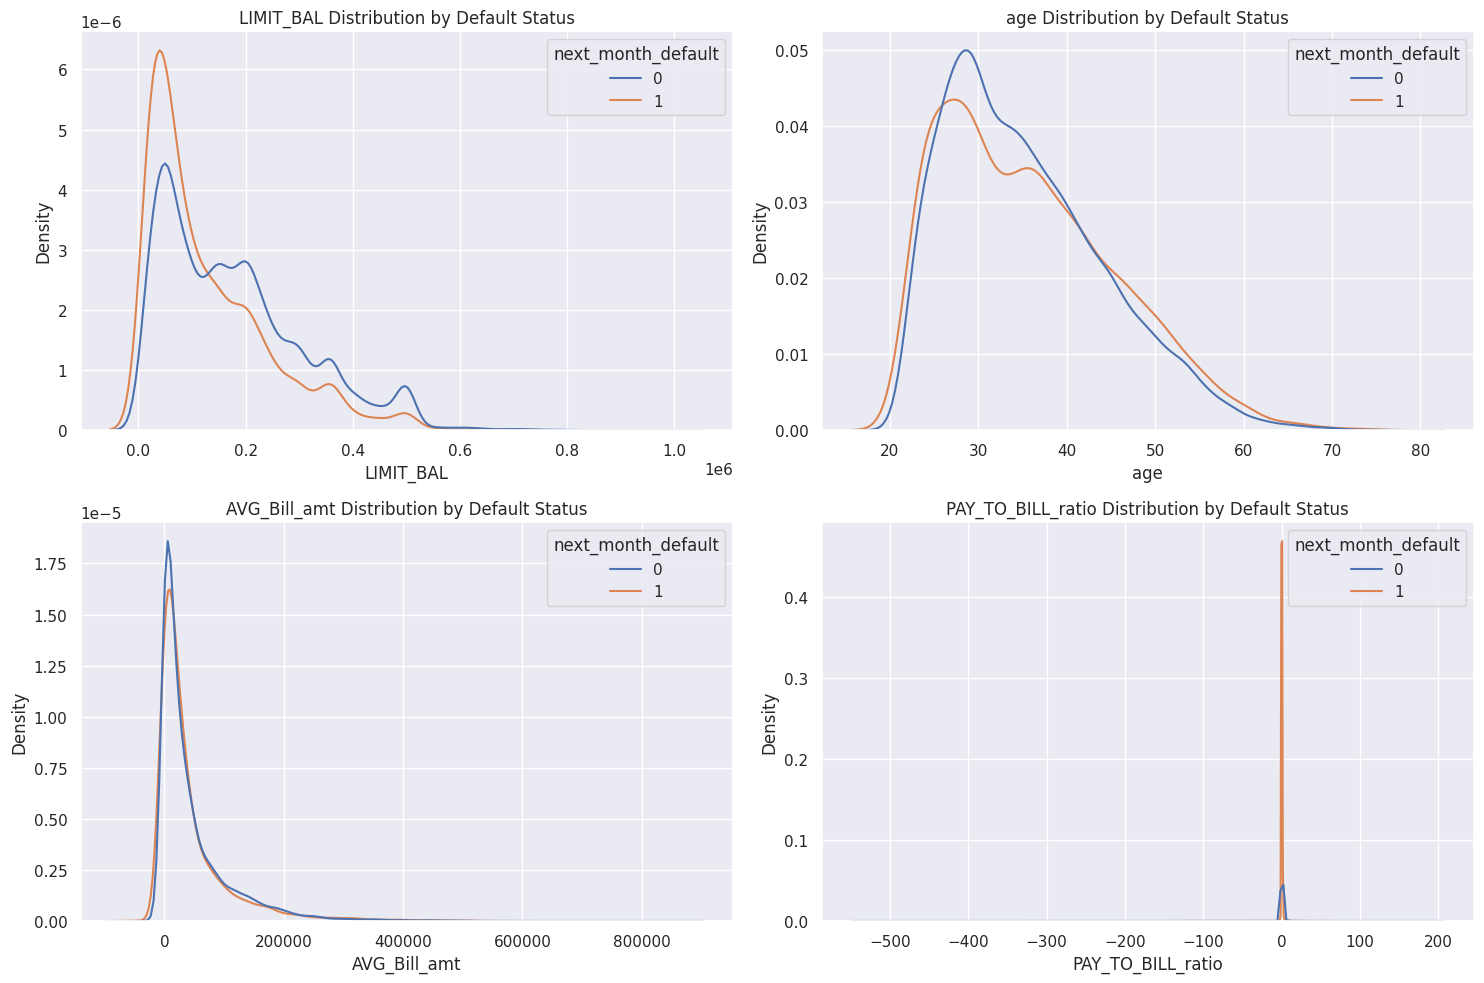

In [ ]:
# Distribution Plots for Key Variables
key_variables = ['LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']

plt.figure(figsize=(15, 10))
for i, var in enumerate(key_variables, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=train_data, x=var, hue='next_month_default', common_norm=False)
    plt.title(f'{var} Distribution by Default Status')
    plt.xlabel(var)
    plt.ylabel('Density')
plt.tight_layout()
plt.savefig('output/key_variables_distribution.png')
plt.show()

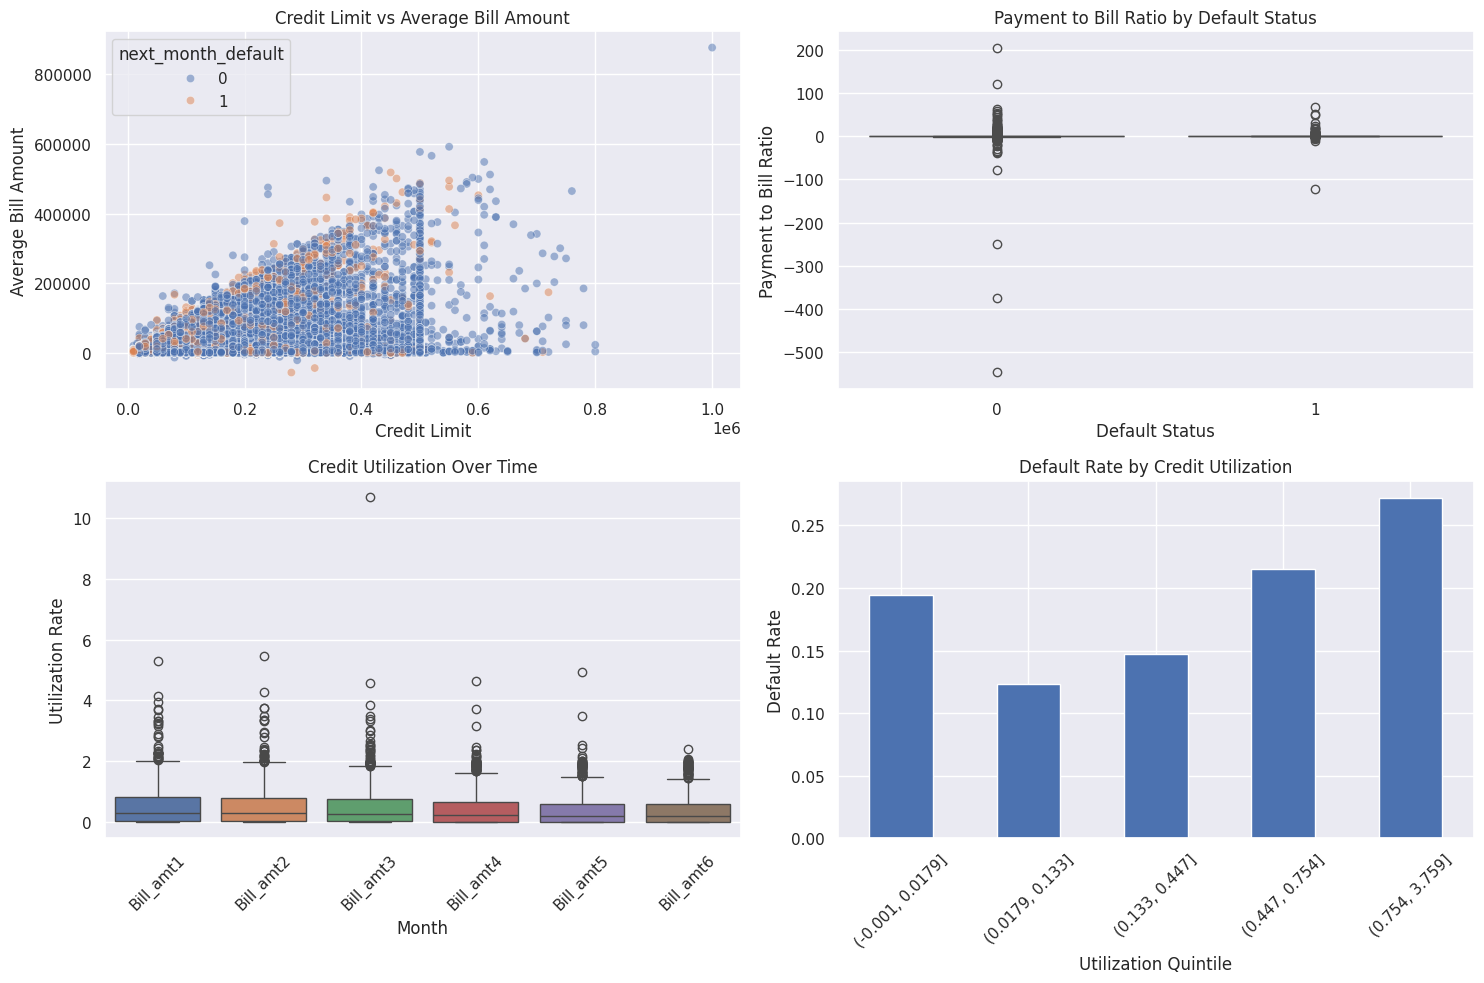

In [ ]:
# Credit Utilization Analysis Plots
plt.figure(figsize=(15, 10))

# 1. Credit Limit vs Bill Amount
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_data, x='LIMIT_BAL', y='AVG_Bill_amt',
                hue='next_month_default', alpha=0.5)
plt.title('Credit Limit vs Average Bill Amount')
plt.xlabel('Credit Limit')
plt.ylabel('Average Bill Amount')

# 2. Payment to Bill Ratio Distribution
plt.subplot(2, 2, 2)
sns.boxplot(data=train_data, x='next_month_default', y='PAY_TO_BILL_ratio')
plt.title('Payment to Bill Ratio by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Payment to Bill Ratio')

# 3. Credit Utilization Over Time
bill_cols = [col for col in train_data.columns if col.startswith('Bill_amt')]
utilization = train_data[bill_cols].div(train_data['LIMIT_BAL'], axis=0)
plt.subplot(2, 2, 3)
sns.boxplot(data=utilization)
plt.title('Credit Utilization Over Time')
plt.xlabel('Month')
plt.ylabel('Utilization Rate')
plt.xticks(rotation=45)

# 4. Utilization vs Default Rate
plt.subplot(2, 2, 4)
utilization_bins = pd.qcut(utilization.mean(axis=1), q=5)
default_by_utilization = train_data.groupby(utilization_bins)['next_month_default'].mean()
default_by_utilization.plot(kind='bar')
plt.title('Default Rate by Credit Utilization')
plt.xlabel('Utilization Quintile')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('output/credit_utilization_analysis.png')
plt.show()

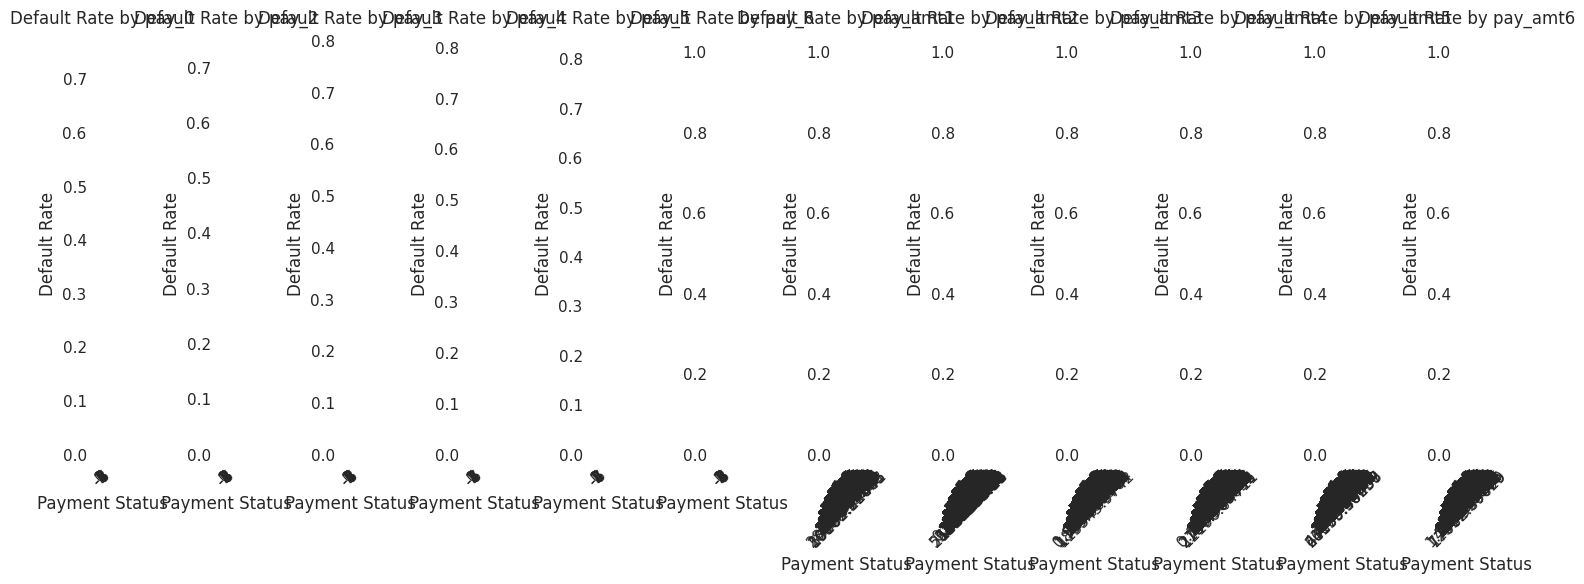

In [ ]:
# Payment History Patterns Visualization
pay_cols = [col for col in train_data.columns if col.startswith('pay_')]
pay_data = train_data[pay_cols].copy()

plt.figure(figsize=(15, 6))
for i, col in enumerate(pay_cols):
    plt.subplot(1, len(pay_cols), i+1)
    default_rate = train_data.groupby(col)['next_month_default'].mean()
    default_rate.plot(kind='bar')
    plt.title(f'Default Rate by {col}')
    plt.xlabel('Payment Status')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/payment_history_patterns.png')
plt.show()

In [ ]:
# Generate EDA Report
def generate_eda_report():
    """Generate comprehensive EDA report"""
    report = []
    report.append("# Exploratory Data Analysis Report\n")

    # Dataset Overview
    report.append("## 1. Dataset Overview")
    report.append(f"- Training Data Shape: {train_data.shape}")
    report.append(f"- Validation Data Shape: {val_data.shape}\n")

    # Target Distribution
    report.append("## 2. Target Distribution")
    report.append(f"- Default Rate: {financial_insights['Default Rate']:.2%}\n")

    # Financial Insights
    report.append("## 3. Financial Insights")
    for key, value in financial_insights.items():
        report.append(f"- {key}: {value:,.2f}")
    report.append("")

    # Key Features
    report.append("## 4. Key Features Analysis")
    report.append("Top 10 features by correlation with target:")
    for feature in key_features:
        report.append(f"- {feature}")
    report.append("")

    # Payment History Analysis
    report.append("## 5. Payment History Analysis")
    report.append("Payment status patterns across months:")
    for col in pay_cols:
        default_rate = train_data.groupby(col)['next_month_default'].mean()
        report.append(f"\n### {col}")
        for status, rate in default_rate.items():
            report.append(f"- Status {status}: Default Rate {rate:.2%}")
    report.append("")

    # Credit Utilization Analysis
    report.append("## 6. Credit Utilization Analysis")
    utilization = train_data[bill_cols].div(train_data['LIMIT_BAL'], axis=0)
    avg_utilization = utilization.mean(axis=1)
    utilization_bins = pd.qcut(avg_utilization, q=5)
    default_by_utilization = train_data.groupby(utilization_bins)['next_month_default'].mean()

    report.append("Default rates by credit utilization quintiles:")
    for quintile, rate in default_by_utilization.items():
        report.append(f"- {quintile}: Default Rate {rate:.2%}")
    report.append("")

    # Key Variables Distribution
    report.append("## 7. Key Variables Distribution")
    for var in key_variables:
        stats = train_data.groupby('next_month_default')[var].describe()
        report.append(f"\n### {var}")
        report.append("Statistics by default status:")
        for status in [0, 1]:
            report.append(f"\nDefault Status: {status}")
            for stat, value in stats.loc[status].items():
                report.append(f"- {stat}: {value:,.2f}")
    report.append("")

    # Save report
    with open('output/eda_report.md', 'w') as f:
        f.write('\n'.join(report))

# Generate and save EDA report
generate_eda_report()
print("EDA report generated and saved to output/eda_report.md")

EDA report generated and saved to output/eda_report.md


3. Data Preprocessing

In [ ]:
def handle_missing_values(df):
    """Handle missing values with optimal strategies per feature"""
    df = df.copy()

    # Payment history features - forward fill as it's time series data
    pay_cols = [col for col in df.columns if col.startswith('pay_')]
    df[pay_cols] = df[pay_cols].fillna(method='ffill')

    # Bill amount features - median as they're financial data
    bill_cols = [col for col in df.columns if col.startswith('Bill_amt')]
    df[bill_cols] = df[bill_cols].fillna(df[bill_cols].median())

    # Payment amount features - median as they're financial data
    pay_amt_cols = [col for col in df.columns if col.startswith('pay_amt')]
    df[pay_amt_cols] = df[pay_amt_cols].fillna(df[pay_amt_cols].median())

    # Demographic features - mode for categorical data
    demographic_cols = ['age', 'sex', 'education', 'marriage']
    for col in demographic_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Credit limit - median as it's financial data
    if 'LIMIT_BAL' in df.columns:
        df['LIMIT_BAL'] = df['LIMIT_BAL'].fillna(df['LIMIT_BAL'].median())

    return df

In [ ]:
train_data = handle_missing_values(train_data)
val_data = handle_missing_values(val_data)

print("Missing values handled")

Missing values handled


4. Feature Engineering

In [ ]:
def engineer_features(df):
    """Engineer new features"""
    df = df.copy()

    # Payment behavior features
    pay_cols = [col for col in df.columns if col.startswith('pay_')]
    df['max_pay_delay'] = df[pay_cols].max(axis=1)
    df['min_pay_delay'] = df[pay_cols].min(axis=1)
    df['mean_pay_delay'] = df[pay_cols].mean(axis=1)
    df['std_pay_delay'] = df[pay_cols].std(axis=1)

    # Bill amount features
    bill_cols = [col for col in df.columns if col.startswith('Bill_amt')]
    df['bill_amount_trend'] = df[bill_cols].diff(axis=1).mean(axis=1)
    df['bill_amount_volatility'] = df[bill_cols].std(axis=1)

    # Payment amount features
    pay_amt_cols = [col for col in df.columns if col.startswith('pay_amt')]
    df['payment_amount_trend'] = df[pay_amt_cols].diff(axis=1).mean(axis=1)
    df['payment_amount_volatility'] = df[pay_amt_cols].std(axis=1)

    # Credit utilization features
    df['credit_utilization'] = df['AVG_Bill_amt'] / df['LIMIT_BAL']

    return df

In [ ]:
train_data = engineer_features(train_data)
val_data = engineer_features(val_data)

print("feature engineering done")

feature engineering done


5. Model Development

In [ ]:
# Handle categorical variables
categorical_cols = ['marriage', 'sex', 'education']
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)
val_data = pd.get_dummies(val_data, columns=categorical_cols, drop_first=True)

# Ensure validation data has same columns as training data
for col in train_data.columns:
    if col not in val_data.columns and col != 'next_month_default':
        val_data[col] = 0
val_data = val_data[train_data.columns.drop('next_month_default')]

# Split features and target
X = train_data.drop(['next_month_default', 'Customer_ID'], axis=1)
y = train_data['next_month_default']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_val = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns
)

In [ ]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"Training data shape after SMOTE: {X_train.shape}")

#class weights
class_weights = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}
print("Class weights:", class_weights)

f2_scorer = make_scorer(fbeta_score, beta=2)

Training data shape after SMOTE: (32704, 41)
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
ensemble_models = {
    'rf': RandomForestClassifier(
        random_state=RANDOM_SEED,
        n_estimators=300,
        max_depth=12,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight=class_weights,
        n_jobs=-1
    ),
    'xgb': XGBClassifier(
        random_state=RANDOM_SEED,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=class_weights[1]/class_weights[0]
    ),
    'lgb': LGBMClassifier(
        random_state=RANDOM_SEED,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight=class_weights
    )
}


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=2000,
        class_weight=class_weights,
        C=0.1
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_SEED,
        max_depth=8,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight=class_weights
    ),
    'Random Forest': ensemble_models['rf'],
    'XGBoost': ensemble_models['xgb'],
    'LightGBM': ensemble_models['lgb'],
    'Ensemble': VotingClassifier(
        estimators=[(name, model) for name, model in ensemble_models.items()],
        voting='soft',
        weights=[1, 1, 1]
    )
}

6. Model Evaluation


In [ ]:
best_f2_score = 0
results = []


Training Logistic Regression...
Cross-validation F2 scores: [0.64701855 0.64320693 0.64660291 0.6388437  0.65385575]
Mean CV F2 score: 0.646 (+/- 0.010)

Logistic Regression Performance:
Optimal Threshold: 0.440
Confusion Matrix:
[[2363 1725]
 [ 243  719]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.58      0.71      4088
           1       0.29      0.75      0.42       962

    accuracy                           0.61      5050
   macro avg       0.60      0.66      0.56      5050
weighted avg       0.79      0.61      0.65      5050


Training Decision Tree...
Cross-validation F2 scores: [0.49405795 0.71973725 0.74150296 0.76594707 0.7469398 ]
Mean CV F2 score: 0.694 (+/- 0.202)

Decision Tree Performance:
Optimal Threshold: 0.300
Confusion Matrix:
[[2370 1718]
 [ 226  736]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.58      0.71      4088
           1  

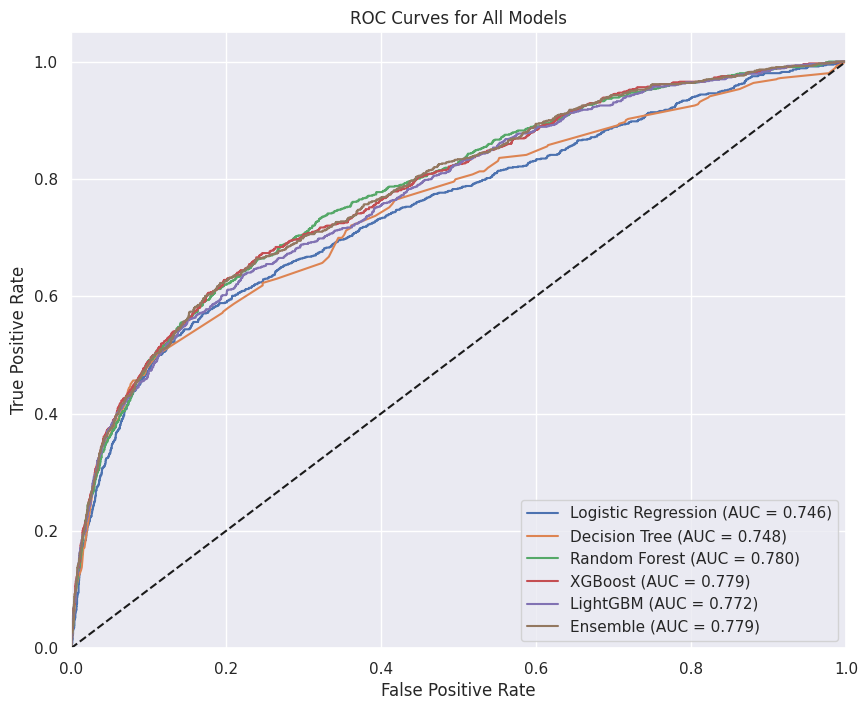


Model Performance Summary:
              Model  Accuracy  Precision   Recall  F2 Score  AUC-ROC  Optimal Threshold  CV F2 Score
Logistic Regression  0.610297   0.294190 0.747401  0.571360 0.746301               0.44     0.645906
      Decision Tree  0.615050   0.299919 0.765073  0.583942 0.748309               0.30     0.693637
      Random Forest  0.519406   0.267386 0.875260  0.601686 0.780175               0.28     0.737612
            XGBoost  0.456832   0.248943 0.917879  0.597025 0.779104               0.24     0.751863
           LightGBM  0.501386   0.260173 0.877339  0.595037 0.772052               0.26     0.750637
           Ensemble  0.582376   0.290157 0.824324  0.602492 0.779296               0.30     0.751711


In [ ]:

# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Add cross-validation with proper F2 scorer
    cv_scores = cross_val_score(model, X_train, y_train,
                             cv=5, scoring=f2_scorer)
    print(f"Cross-validation F2 scores: {cv_scores}")
    print(f"Mean CV F2 score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    model.fit(X_train, y_train)

    # Get probability predictions
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Find optimal threshold for F2 score
    thresholds = np.arange(0.1, 1.0, 0.02)
    f2_scores = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f2 = fbeta_score(y_val, y_pred, beta=2)
        f2_scores.append(f2)

    optimal_threshold = thresholds[np.argmax(f2_scores)]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f2 = fbeta_score(y_val, y_pred, beta=2)
    auc_roc = roc_auc_score(y_val, y_pred_proba)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F2 Score': f2,
        'AUC-ROC': auc_roc,
        'Optimal Threshold': optimal_threshold,
        'CV F2 Score': cv_scores.mean()
    })

    print(f"\n{name} Performance:")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    if f2 > best_f2_score:
        best_f2_score = f2
        best_model = model
        best_threshold = optimal_threshold

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.savefig('output/roc_curves.png')
plt.show()

# Save results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))
results_df.to_csv('output/model_performance.csv', index=False)


In [ ]:
# Feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature')
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.savefig('output/feature_importance.png')
    plt.show()

    # Save feature importance to CSV
    feature_importance.to_csv('output/feature_importance.csv', index=False)

    # Generate SHAP values for model explainability
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_val, plot_type="bar")
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('output/shap_importance.png')
    plt.show()

7. Final Predictions

In [ ]:
# Scale validation data
print("Preparing validation data for prediction...")
# Drop Customer_ID before scaling
val_data_features = val_data.drop('Customer_ID', axis=1)

# Scale validation data
val_data_scaled = pd.DataFrame(
    scaler.transform(val_data_features),
    columns=val_data_features.columns
)

# Generate probability predictions
print("Generating predictions...")
predictions_proba = best_model.predict_proba(val_data_scaled)[:, 1]

# Apply optimal threshold
predictions = (predictions_proba >= best_threshold).astype(int)

# Save predictions
results = pd.DataFrame({
    'Customer': val_data['Customer_ID'],  # Use original Customer_ID
    'next_month_default': predictions
})
results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")
print(f"Using optimal threshold: {best_threshold:.3f}")


Preparing validation data for prediction...
Generating predictions...
Predictions saved to predictions.csv
Using optimal threshold: 0.300


In [ ]:
print("\nDownloading results and analysis files...")

# Dictionary of files to download with their paths and descriptions
files_to_download = {
    'predictions.csv': 'Final predictions',
    'output/model_performance.csv': 'Model performance metrics',
    'output/eda_report.md': 'EDA analysis report',
    'output/correlation_matrix.png': 'Correlation matrix visualization',
    'output/feature_distributions.png': 'Feature distributions',
    'output/key_variables_distribution.png': 'Key variables analysis',
    'output/payment_history_patterns.png': 'Payment history patterns',
    'output/credit_utilization_analysis.png': 'Credit utilization analysis',
    'output/default_distribution.png': 'Default status distribution',
    'output/target_correlations.csv': 'Target variable correlations',
    'output/financial_insights.csv': 'Financial insights data'
}

# Download each file if it exists
for file_path, description in files_to_download.items():
    if os.path.exists(file_path):
        files.download(file_path)
        print(f"✓ Downloaded {description} ({file_path})")
    else:
        print(f"× {description} not found ({file_path})")

# Download feature importance files for each model
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
for model in model_names:
    file_path = f'output/feature_importance_{model.lower().replace(" ", "_")}.csv'
    if os.path.exists(file_path):
        files.download(file_path)
        print(f"✓ Downloaded feature importance for {model}")
    else:
        print(f"× Feature importance for {model} not found")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Final predictions (predictions.csv)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Model performance metrics (output/model_performance.csv)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded EDA analysis report (output/eda_report.md)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Correlation matrix visualization (output/correlation_matrix.png)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Feature distributions (output/feature_distributions.png)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Key variables analysis (output/key_variables_distribution.png)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Payment history patterns (output/payment_history_patterns.png)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Credit utilization analysis (output/credit_utilization_analysis.png)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Default status distribution (output/default_distribution.png)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Target variable correlations (output/target_correlations.csv)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded Financial insights data (output/financial_insights.csv)
× Feature importance for Random Forest not found
× Feature importance for XGBoost not found
× Feature importance for LightGBM not found
